In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

# Forecasting time series of US real estate sales data
In this section it is tried to build a model for predicting prices of real estate sales in the US.
The time series is generated by aggregating data of individual sales. 
The aim is to predict median (typical) prices on quarterly prediction interval.

## Loading the data and building the time series

In [2]:
df_raw = pd.read_csv('raw_sales.csv') #Load data from csv-file

# Set up a ordered categorical datatype to handle no. of bedrooms
replace_dic={0: 'zero', 
             1: 'one',
             2: 'two',
             3: 'three',
             4: 'four',
             5: 'five'}
ordered_bedrooms = pd.Series(sorted(set(df_raw.bedrooms))).replace(replace_dic)
bedroom_type = pd.CategoricalDtype(categories=ordered_bedrooms, ordered=True)



def tweak_sales(df_):
    """Function convert dates to datetime-objects and pushes them into the index.
    Then, time series for prices of real estate on quarterly basis are build by grouping and aggregation."""
    return(df_.assign(quarter=lambda s: pd.to_datetime(s.datesold).dt.to_period('Q'), #create date of sale
                                                                                      #as DateTime-Object quarters
                      price=lambda s: s.price/1000) #Express all prices in thousands $
           .drop(['datesold', 'postcode', 'propertyType'], axis='columns') #Delete old datesold, propertyType 
                                                                           #and postal code column, 
                                                                           #focus on price information
           .groupby(by=['quarter', 'bedrooms']) #Grouping with numbers of bedrooms, as this is indicator of size 
                                             #of real estate object. Grouping by date-column to obtain quarterly
                                             #data
           .price.median() #Aggregate meadian of prices instead of mean of prices, to minimize effect of outliers
           .unstack()  #Unstack group-object to obtain DataFrame
           .set_axis(pd.Index(data=ordered_bedrooms, dtype=bedroom_type, name='bedrooms'), axis=1) #set CatDtype
           .drop('zero', axis='columns') #Exclude real estate with zero bedrooms, hardly any data of zero bedrooms
           .bfill() #Missing data occurs at the beginning of columns (up to two each column). These are filled
                    #with values occuring right after the period of missing values. Meaning to assume, that 
                    #median prices didn't change over the period of missing data.
           .to_timestamp(how='end')
           .asfreq(freq='Q-DEC')
           )





In [3]:
# Customizing raw data DataFrame
df = tweak_sales(df_raw)
# Splitting DataFrame in test and train DataFrame with fraction beeing the fraction of training data
fraction = 0.8
boundary = int(fraction * (df.index.size - 1))
df_train = df.iloc[:boundary]
df_test = df.iloc[boundary:]

## Goal is to invent different models for same series starting with three bedroom real estate price time series. Later all predictions gained will be averaged.

### Befor training models: investigate time series by plotting

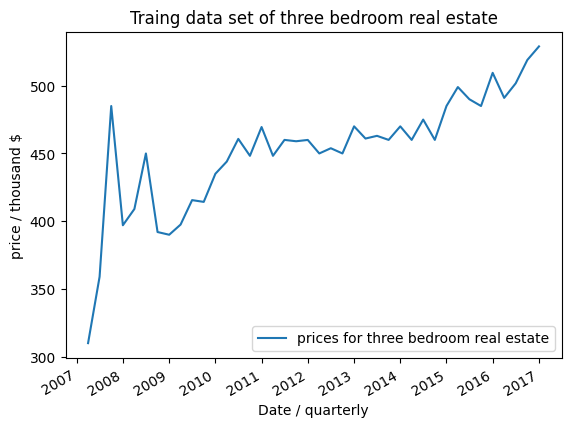

In [4]:
ax = df_train.three.plot(title='Traing data set of three bedroom real estate', legend=True)
ax.set(xlabel='Date / quarterly', ylabel='price / thousand $')
#ax.set_label(legend='prices for three bedroom real estate')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['prices for three bedroom real estate'], loc='lower right')


### Befor training: Investigate time series by STL decomposition


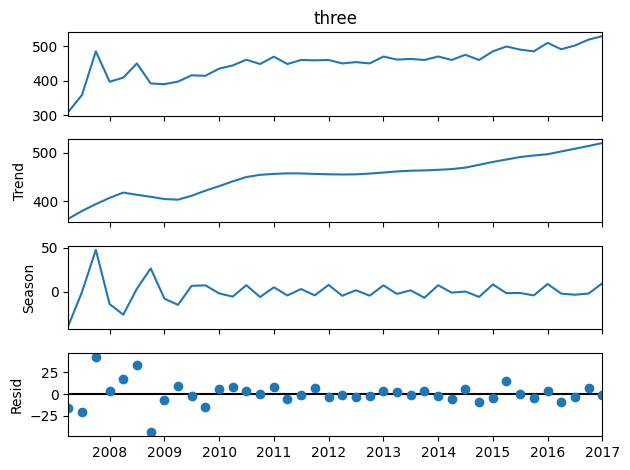

In [5]:
STL_result = STL(df_train.three, period=4, seasonal=7).fit()
fig = STL_result.plot()
# From the residuals it may be concluded, that variance was much greater within the years of 2008 and 2009.
# This would stay in contrast to desired stationarity. Applying APS test should clarify, if residuals are 
# staionary

In [6]:
# Calculating the ADF test to clarify if residuals are stationary
ADF_crit_value, ADF_p_value, _, _, crit_value_dict, _ = adfuller(STL_result.resid.values, maxlag=12, 
         regression='n') # 'n' for no constant or linear trend to include
# Print results of adjusted Dickey-Fuller-Test
print('Results of ADF-Test\np-value = ', ADF_p_value, '\nCritical values for test statistics are:')
for i, item in enumerate(crit_value_dict.items()):
    print('Critical value for '+item[0], ' ' * (12 - len(item[0])), ':', item[1])
print('Observerd test statistic value is:', ADF_crit_value)
print('\nNull-hypothesis is rejected and alternative, that Residuals are stationary and without unit root is accepted.')

Results of ADF-Test
p-value =  0.00011663481372058212 
Critical values for test statistics are:
Critical value for 1%            : -2.6416367741935485
Critical value for 5%            : -1.9521180087946024
Critical value for 10%           : -1.6102250015105233
Observerd test statistic value is: -3.8809179997266257

Null-hypothesis is rejected and alternative, that Residuals are stationary and without unit root is accepted.


[Text(0.5, 36.72222222222221, 'Lag order'),
 Text(510.4494949494949, 0.5, 'Partial auto correlation')]

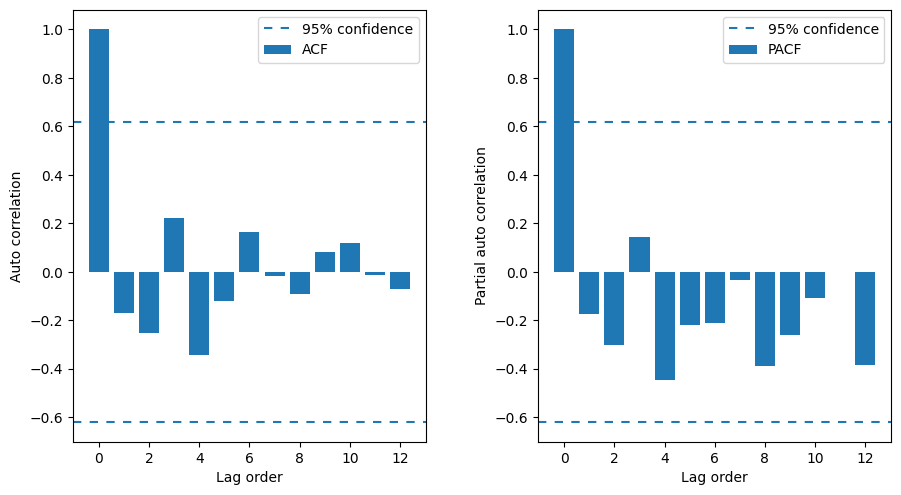

In [7]:
# As residuals are considered stationary, (partial) auto correlation function are plotted
# to facilitate model selection
# Calculating autocorrelation of residuals, defining 95% significance interval,
# qstat=True will provide test statistics for potential Ljung-Box-Test
acf_result, acf_intervals, q_statistics, p_values = acf(STL_result.resid, nlags=12, alpha=0.05, qstat=True)
    
# Calculating partial autocorrelation of residuals
pacf_result, pacf_intervals = pacf(STL_result.resid, nlags=12, alpha=0.05) #returns partial autocorrelation 
                                                                           #and confidence interval 
                                                                           #boundaries for 95 % 
    
# Confidence intervals for acf in this case are calculated from formular 1/sqrt(N-2)
acf_confidence = 1.96 * 1/np.sqrt(len(acf_result) - 3) # for 95% interval
# Calculate confidence interval from span of interval of last calculated itnerval
# Confidence interval is same for all lags > 0, it depends from nlags defined in pacf-function.
# Here we will plot confidence interal around 0, to measure, whether pacf of some lags significantly
# differ from 0.
pacf_confidence = abs(np.diff(pacf_intervals, axis=1)[-1][-1])


# Plotting (partial) autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.tight_layout(pad=5)
axes[0].bar(np.arange(len(acf_result)), acf_result, label='ACF')
axes[0].axhline(-acf_confidence, dashes=(4, 4), label='95% confidence')
axes[0].axhline(acf_confidence, dashes=(4, 4))
axes[0].legend()
axes[0].set(xlabel='Lag order', ylabel='Auto correlation')
axes[1].bar(np.arange(len(pacf_result)), pacf_result, label='PACF')
axes[1].axhline(-pacf_confidence, dashes=(4, 4), label='95% confidence')
axes[1].axhline(pacf_confidence, dashes=(4, 4))
axes[1].legend()
axes[1].set(xlabel='Lag order', ylabel='Partial auto correlation')

There are no significant partial auto correlation or auto correlation contributions among the first 12 lags (so over a period of 3 years). This is to be considered, when chosing auto regressive or moving average models. To verify this, Ljung-Box test is calculated. Calculation from function statsmodels.tsa.stattools is not used, as degrees of freedom consumed by decomposition can't be set. Hypotheses of Ljung-Box-Test are:

H0: The data are independently distributed

H1: The data are not independently distributed; they exhibit serial correlation.

In [8]:
# Calculating Ljung-Box-Test with 1 degree of freedom consumend by decomposition (one period component)
Ljung_Box_result = (acorr_ljungbox(STL_result.resid, lags=12, model_df=1)
                    .reset_index() #Take Lags from index to new column
                    .rename(columns={'index': 'Lags', # Name column containing the lags "Lags"
                                     'lb_stat': 'Q-stat', # Name column containing test statistics "Q-stat"
                                     'lb_pvalue': 'p_value'}) # Name column containing p-values "p-values"
                    .assign(H0_reject=lambda s: s.p_value<0.05) # New column indicating where 
                                                                # H0 can be rejected
                   )
Ljung_Box_result

,Lags,Q-stat,p_value,H0_reject
0,1,1.234742,NaN,False
1,2,4.018030,0.045016,True
2,3,6.226677,0.044452,True
3,4,11.782745,0.008166,True
4,5,12.479692,0.014119,True
5,6,13.830793,0.016721,True
6,7,13.846015,0.031404,True
7,8,14.296097,0.046159,True
8,9,14.649871,0.066322,False
9,10,15.436476,0.079624,False


Interestingly for some lags H0 of Ljung-Box test can be rejected on an significance level of 5%. This may indicate, that models taking autocorrelation of residuals into account might be suitable, nontheless the values of acf and pacf where below the threshold. Models including autocorrelation should be compared to models who don't by information criteria in following section.

### 1. Model: STL forecast, using ARIMA to forecast deseasonalized series

STL-forecasting uses naive forecasting of seasonal component, trend component is modelled from a specified model, ARIMA in this case.

In [9]:
# Defining dictionary of argmuments passed to ARIMA model
ARIMA_args = {'order': (0, 1, 0), 'seasonal_order': (0, 0, 0, 0)}
# Creating instance of STLForecast, parameters like in decompositione example above. ARIMA model with 
# dictonary of arguments.
STL_naive = STLForecast(df_train.three, model=ARIMA, 
                              model_kwargs=ARIMA_args, period=4, seasonal=7)

# Fitting model to training data set
STL_naive_result = STL_naive.fit()
# Calculating multible time step forecast on test data set and prediction on training data set as whole
predict_all_series = STL_naive_result.get_prediction(start='2007', end='2020')
# Calculate prediction confidence interval for 90% for forecast period
conf_int_all_series = STL_naive_result.get_prediction(start=boundary, end='2020').conf_int(alpha=0.1)

Text(0.5, 1.0, 'Training period and prediction of\nthree bedroom real estate prices')

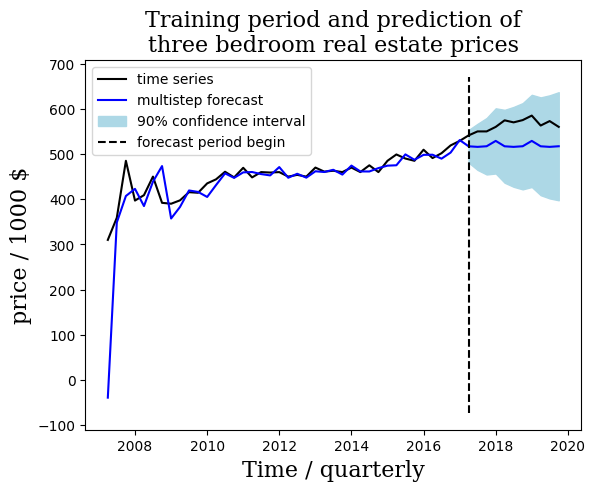

In [29]:
# Fill results of prediction on training data, point forecast on test data,
# standard deviation and confidence interval on test data into same dataframe as time series data
df = df.assign(STL_ARIMA_three=predict_all_series.predicted_mean,
               STL_ARIMA_std_three=predict_all_series.se_mean,
               STL_ARIMA_90_lower=conf_int_all_series.lower,
               STL_ARIMA_90_upper=conf_int_all_series.upper)

# defining font for labels and title of following plot
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

# Plot time series together with prediction and forecast and its confidence interval
fig, ax = plt.subplots()
ax.plot(df.three, color='black', label='time series')
ax.plot(df.STL_ARIMA_three, color='blue', label='multistep forecast')
# Confidence interval plotting
ax.fill_between(df.loc['2017-01':].index, df.loc['2017-01':].STL_ARIMA_90_lower, 
                df.loc['2017-01':].STL_ARIMA_90_upper, color='lightblue', label='90% confidence interval')
ax.vlines(df.index[boundary], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='black', 
          linestyles='dashed', label='forecast period begin')

# Labels and legends:
ax.legend()
ax.set_xlabel('Time / quarterly', fontdict=font)
ax.set_ylabel('price / 1000 $', fontdict=font)
#ax.set_x_tics(1)
ax.set_title('Training period and prediction of\nthree bedroom real estate prices', fontdict=font)